# CNN para análise de sentimento

In [ ]:
# Obs.: run before everything and then restart the runtime!
!pip install spacy
!python -m spacy download pt_core_news_sm

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186282 sha256=a41d3e474526aa42249b038571f247dd57738595fbddc2e4144a8ac2b8b3ccb8
  Stored in directory: /tmp/pip-ephem-wheel-cache-1cc3b88i/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [ ]:
import pandas as pd

#create DataFrame with commmentaries and number of stars
data_path = '/content/drive/My Drive/data/'
df = pd.read_csv(data_path+'comentarios_dados.csv',sep=';')
print("File loaded sucessfully!")
df = pd.concat([df, pd.get_dummies(df['n° estrelas'],prefix='estrelas')], axis=1) 
df.drop(['n° estrelas'], axis=1, inplace=True)

File loaded sucessfully!


In [ ]:
# divide texts and labels
text_data = df['conteúdo'].to_numpy()
label_data = df[['estrelas_1', 'estrelas_2', 'estrelas_3', 'estrelas_4', 'estrelas_5']].to_numpy()

In [ ]:
import spacy
nlp = spacy.load('pt_core_news_sm')

!pip install unidecode
from unidecode import unidecode
# word lemmatization (base form)
def lemmatizer(text:str) -> str:
    sent = []
    doc = nlp(text)
    for word in doc:
        if word.pos_ in ["VERB"]:
            sent.append(word.lemma_)
        else:
            sent.append(word.orth_)
    return " ".join(sent)

# text standardization
def text_padr(text:str) -> str:
    text = text.strip().replace('\n', '')
    text = text.lower()
    text = unidecode(text)
    text = lemmatizer(text)
    return text

from tqdm import tqdm
text_data = [text_padr(str(text)) for text in tqdm(text_data)]

print("\nText standardization concluded!\n")

  0%|                                                                             | 17/206785 [00:00<20:53, 165.01it/s]

100%|█████████████████████████████████████████████████████████████████████████| 206785/206785 [23:09<00:00, 148.77it/s]


Text standardization concluded!



In [ ]:
# save lemmatized text data
import pickle

data_path = '/content/drive/My Drive/data/'
with open(f'{data_path}lemmatized_texts.pickle','wb') as f:
    pickle.dump(text_data, f)

In [ ]:
# load lemmatized text data
import pickle
import numpy as np

with open(data_path+'lemmatized_texts.pickle','rb') as f:
    text_data = np.asarray(pickle.load(file=f))

In [ ]:
g_path='/content/drive/My Drive/data/glove_s100.txt'
with open(g_path,'r') as f:
    g_file = f.readlines()[1:]
    with open('file_for_aug_model.txt','w') as gf:
        gf.writelines(g_file)

In [ ]:
# data balanced with random undersampling
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
runsamp = RandomUnderSampler(sampling_strategy='auto')
text_data = np.expand_dims(text_data, axis=-1)
print("balancing data...")
text_data, label_data = runsamp.fit_resample(text_data, label_data)
# return text_data list to its original shape
text_data = np.squeeze(text_data)
print(f"data undersampling concluded! Total number of examples: {len(text_data)} ")

print("Mean text length: ", np.mean([len(txt) for txt in text_data]),"\n",
      "Standard deviation: ", np.std([len(txt) for txt in text_data]), "\n")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


balancing data...


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


data undersampling concluded! Total number of examples: 29065 
Mean text length:  191.5015654567349 
 Standard deviation:  159.117799494289 



In [ ]:
!pip install nlpaug

     |████████████████████████████████| 102kB 2.3MB/s 


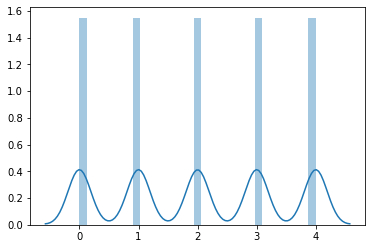

In [ ]:
import seaborn as sns
sns.distplot(np.array([np.argmax(lbl) for lbl in label_data]))

In [ ]:
!pip install nlpaug

     |████████████████████████████████| 102kB 2.3MB/s 


In [ ]:
# data augmentation using pretrained embeddings

import nlpaug.augmenter.word as naw 
import nlpaug.model.word_embs as nmw
import numpy as np
from tqdm import tqdm

print("Loading GloVe model...")

glove_model = nmw.GloVe()
g_path=data_path+'glove_s100.txt'

with open(g_path,'r') as f:
    g_file = f.readlines()
# remove header from file
with open('embed_file.txt', 'w') as f:
    f.writelines(g_file[1:])

glove_model.read('embed_file.txt')
print(f"{g_path} file loaded!")

aug = naw.WordEmbsAug(
    model_type='glove',
    model=glove_model,
    action="substitute"
)

print("augmenter ready for use.")

Loading GloVe model...
/content/drive/My Drive/data/glove_s100.txt file loaded!
augmenter ready for use.


In [ ]:
# create train and test datasets
from sklearn.model_selection import train_test_split
text_train, text_test, labels_train, labels_test = train_test_split(
    text_data, label_data, test_size=0.1, random_state=123
)

In [ ]:
# tokenize sentences
#Getting the maximum length of strings for truncation. (=141 in this case)
max_length = int(np.mean([len(txt) for txt in text_data])) # média dos valores de tamanho de texto
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# create the Tokenizer object
tokenizer = Tokenizer(num_words=20000,oov_token=oov_tok)
# fit the tokenizer only to the training texts
tokenizer.fit_on_texts(text_train)
# get the dictionary of word indexes
word_index = tokenizer.word_index
# tokenize and pad texts
text_train = tokenizer.texts_to_sequences(text_train)
text_test = tokenizer.texts_to_sequences(text_test)
text_train = pad_sequences(text_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
text_test = pad_sequences(text_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# export data
data_path = '/content/drive/My Drive/data/'
np.savez_compressed(f'{data_path}Training_Data.npz',text_train,labels_train)
np.savez_compressed(f'{data_path}Test_Data.npz',text_test,labels_test)
np.savez_compressed(f'{data_path}Word_Index.npz',word_index)
print(f"\nPreprocessing finished! \nFiles saved to {data_path}.")


Preprocessing finished! 
Files saved to /content/drive/My Drive/data/.


In [ ]:
 # load data
 import numpy as np
 data_path = '/content/drive/My Drive/data/'
 text_train = np.load(f'{data_path}Training_Data.npz', allow_pickle=True)['arr_0']
 labels_train = np.load(f'{data_path}Training_Data.npz', allow_pickle=True)['arr_1']
 word_index = np.load(f'{data_path}Word_Index.npz', allow_pickle=True)['arr_0'].item()
 print('Files loaded!')

Files loaded!


In [ ]:
# initialize pre-trained embedding matrix
from tqdm import tqdm
def load_embeddings(path_to_glove_file, vocab_dict):
    embeddings = {}
    with open(path_to_glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip(' ').split(' ')
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    vocab_size = len(vocab_dict)
    embedding_size = len(embeddings["vetor"])
    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0

    # if the word is in the glove vector database, then we load the pre-trained vetor
    # but if it isn't we let the random values for later training
    print("Initiating embeddings")
    for w, i in tqdm(vocab_dict.items()):
        if embeddings.get(w) is not None:
            v = embeddings.get(w)
            if v != '<OOV>' and i < vocab_size:
                embedding_matrix[i] = v
                num_loaded += 1
        else:
            continue
   
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

#data_path = '.\\'
pretrained_embs_file = 'glove_s100.txt'
glove_embedding_matrix = load_embeddings(data_path+pretrained_embs_file,word_index)



  0%|          | 0/17814 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 10%|▉         | 1724/17814 [00:00<00:00, 17239.24it/s]

Initiating embeddings




 18%|█▊        | 3240/17814 [00:00<00:00, 16553.01it/s]

 23%|██▎       | 4138/17814 [00:00<00:01, 13209.07it/s]

 33%|███▎      | 5906/17814 [00:00<00:00, 14292.34it/s]

 39%|███▉      | 7025/17814 [00:00<00:00, 12847.06it/s]

 50%|█████     | 8909/17814 [00:00<00:00, 14198.78it/s]

 61%|██████▏   | 10944/17814 [00:00<00:00, 15614.51it/s]

 70%|███████   | 12487/17814 [00:00<00:00, 14196.87it/s]

 79%|███████▉  | 14064/17814 [00:00<00:00, 14633.05it/s]

100%|██████████| 17814/17814 [00:01<00:00, 15348.37it/s]


In [ ]:
# saving embedding matrix
np.savez(f'{data_path}{pretrained_embs_file.split(".")[0]}.npz', glove_embedding_matrix)

In [ ]:
# loading embedding matrix
file_name = 'glove_s100.npz'
glove_embedding_matrix = np.load(data_path+file_name, allow_pickle=True)['arr_0']

In [ ]:
# building the Convolutional Neural Network
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dense, Dropout, \
                                    concatenate, Embedding, Reshape, \
                                    Bidirectional, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
import sys

def build_model(
                window_sizes, feature_maps, sent_size, num_categs, num_depth, 
                layer_width, embedding_matrix:np.array, batch_norm=True
                ):
    inputs = Input(shape=(sent_size), dtype='float32', name='text_inputs') # dim = (BATCH_SIZE, sent_size, embedding_dim)
    
    # initialize the embeddings with my own embeddings matrix
    embed = Embedding(31818, 100, 
                      mask_zero=True, input_length=sent_size, 
                      name='embedding_layer')(inputs)

    #create array for max pooled vectors of features 
    ta = []

    # as we have multiple window sizes:
    for n_window in window_sizes:
        con = Conv1D(feature_maps, n_window, padding='causal', 
                     activation="relu", use_bias=True)(embed) # (BATCH_SIZE, sent_size-window_size+1, feature_maps)
        # the convoluted tensor contains, for each window a feature map of dimension feature_maps
        pooled = GlobalMaxPool1D(data_format='channels_last')(con) # (BATCH_SIZE, sent_size-windows_size+1)
        # then, the max pooling operation extracts the maximum of each feature map, reducing the rank of the tensor
        # the max pooled tensor contains a feature for each window
        if batch_norm:
            pooled = BatchNormalization(trainable=True)(pooled)
        ta.append(pooled)
    
    concat = concatenate(ta, axis=1)
    X = Dropout(0.5)(concat)
    
    #create the dense layers
    for i in range(num_depth):
        X = Dense(layer_width,activation="relu",name=f"dense_layer_{i}")(X)
        X = Dropout(0.5, name=f"dropout_{i}")(X)
        X = BatchNormalization(trainable=True, name=f"batch_norm_{i}")(X)

    outputs = Dense(num_categs,activation="softmax",use_bias=True, kernel_regularizer=l2(l=3),
                   kernel_constraint=Dropout(0.5))(X)
    
    # create the model
    model = Model(inputs=[inputs], outputs=[outputs])

    #return the model
    return model

In [ ]:
window_sizes = [2, 3, 4]
feature_maps = 128
num_categs = 5
layer_width = 256
num_depth = 1
max_length = 191

nlp_model = build_model(window_sizes, feature_maps, max_length, num_categs, 
                        num_depth, layer_width, glove_embedding_matrix)
nlp_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_inputs (InputLayer)        [(None, 191)]        0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 191, 100)     3181800     text_inputs[0][0]                
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 191, 128)     25728       embedding_layer[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 191, 128)     38528       embedding_layer[0][0]            
______________________________________________________________________________________________

In [ ]:
# Treinando o modelo

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os

X_data = text_train
y_data = labels_train

opt = Adam()
loss_fn = CategoricalCrossentropy()
my_metrics = [
           CategoricalAccuracy()
]
nlp_model.compile(optimizer = opt, loss = loss_fn, metrics = my_metrics)

model_path = data_path+"saved_nlp_model/"
if not os.path.isdir(model_path):
    try:
        os.mkdir(model_path)
    except OSError:
        print ("\nCreation of the directory %s failed \n" % model_path)
    else:
        print ("\nSuccessfully created the directory %s \n" % model_path)
else:
    print("\nDirectory %s already exists" % model_path)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

learning_rate_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint(data_path+'tf_ckpts/', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

history = nlp_model.fit(
    X_data,
    y_data,
    batch_size = 200,
    epochs = 100,
    validation_split = 0.05,
    verbose = 1,
    callbacks = [checkpoint, early_stopping, learning_rate_scheduler]
)

nlp_model.save(model_path, save_format='tf')


Directory /content/drive/My Drive/data/saved_nlp_model/ already exists
Epoch 1/100
125/125 [==============================] - 91s 728ms/step - loss: 11.3922 - categorical_accuracy: 0.4396 - val_loss: 3.0245 - val_categorical_accuracy: 0.5145 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 90s 724ms/step - loss: 1.6732 - categorical_accuracy: 0.6685 - val_loss: 1.7206 - val_categorical_accuracy: 0.4174 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 91s 724ms/step - loss: 1.2476 - categorical_accuracy: 0.7428 - val_loss: 1.6309 - val_categorical_accuracy: 0.6537 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 91s 727ms/step - loss: 1.0929 - categorical_accuracy: 0.8054 - val_loss: 1.4511 - val_categorical_accuracy: 0.7424 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 92s 733ms/step - loss: 0.9658 - categorical_accuracy: 0.8606 - val_loss: 1.1950 - val_categorical_accuracy: 0.7936 - lr: 0.0010
Epoch 6/100


In [ ]:
labels_predict = nlp_model.predict(text_test)

In [ ]:
nlp_model.evaluate(text_test, labels_test, batch_size=200)

15/15 [==============================] - 2s 159ms/step - loss: 0.6847 - categorical_accuracy: 0.8332


[0.684732973575592, 0.8331613540649414]

In [ ]:
def untokenize(tokenized_text_list, word_index):
    index_word = {v: k for k, v in word_index.items()}

    def untok_sent(text, index_word):
        sent = []
        for word in text:
            if word != 0:
                sent.append(index_word[word])
        return " ".join(sent)
    
    return [untok_sent(text, index_word) for text in tokenized_text_list]

In [ ]:
def to_stars(label_list):
    return ['*'*(int(lbl)+1) for lbl in label_list]

In [ ]:
import pandas as pd
predict_df = pd.DataFrame(
    data=np.transpose(
          [untokenize(text_test, word_index),
          to_stars([np.argmax(lbl) for lbl in labels_predict]), 
          to_stars([np.argmax(lbl) for lbl in labels_test])
          ]), 
    columns=['Texto (pré-processado)','Label predita','Label verdadeira']
)

In [ ]:
predict_df.head(10)

,Texto (pré-processado),Label predita,Label verdadeira
0,eu achar que nao cumprir o que prometer na int...,**,**
1,espaco ter de sobra o motor nao e muito forte ...,**,**
2,a porta da geladeira e do forno estao emperrar...,**,**
3,otimo e o melhor investimento que ja fiz ate h...,*****,*****
4,produto de baixa qualidade acabamento ruim e i...,**,**
5,pelo amor nao comprar este merda investir 200 ...,*,*
6,excelente controle original e muito bonito,*****,*****
7,excelente produto de boa qualidade muito bem a...,*****,*****
8,produto bom mas ja foi aberto nao vir pelicula...,**,**
9,otimo produto apesar de vir somente no plastic...,*****,*****


In [ ]:
nlp_loaded_model = tf.keras.models.load_model(data_path+'saved_nlp_model/')

In [ ]:
nlp_loaded_model.evaluate(text_test, labels_test)

91/91 [==============================] - 3s 31ms/step - loss: 0.6847 - categorical_accuracy: 0.8332


[0.6847328543663025, 0.8331613540649414]

In [ ]:
import numpy as np

In [ ]:
# trying to augment the training set
text_train_untok = untokenize(text_train,word_index)
augmented_text_train = [aug.augment(text) for text in text_train_untok]
text_train_aug = np.concatenate((text_train_untok, augmented_text_train))
labels_train_aug = np.concatenate((labels_train, labels_train))

In [ ]:
data_path = '/content/drive/My Drive/data/'
np.savez_compressed(f'{data_path}Training_aug_Data.npz',text_train_aug,labels_train_aug)

NameError: ignored